# Proyecto Talento TECH - Pronosticos de demanda

### Contenido de cada columna:
- PAÍS: Nombre del país
- CODE_TIME: Un código que representa el mes y el año (p. ej., JAN2010 para enero de 2010)
- TIME: El mes y el año en un formato más legible para humanos (p. ej., enero de 2010)
- YEAR: El año del punto de datos
- MONTH: El mes del punto de datos como un número (1-12)
- MONTH_NAME: El mes del punto de datos como una cadena (p. ej., enero)
- PRODUCT: El tipo de producto energético (p. ej., hidroeléctrico, eólico, solar)
- VALUE: La cantidad de electricidad generada en gigavatios-hora (GWh)
- DISPLAY_ORDER: El orden en el que se deben mostrar los productos
- yearToDate: La cantidad de electricidad generada durante el año actual hasta el mes actual en GWh
- previousYearToDate: La cantidad de electricidad generada durante el año anterior hasta el mes actual en GWh
- share: La participación del producto en la generación total de electricidad para el país en formato decimal

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



In [4]:
# Cargar el archivo con el delimitador correcto (;)
file_path = '/home/gerardo/proyecto_energia/datasets/databproduction.csv'
df = pd.read_csv(file_path, delimiter=";")
df.head()




,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728,1,16.471.891,NaN,0.04777072935264173
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469,2,4.940.909,NaN,0.01974369632966552
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216,3,908.238,NaN,0.0023730874829616362
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083,4,0.996,NaN,"4,00E+09"
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.73,7,214.302.969,NaN,0.9301084365391247


In [5]:
df.dtypes

COUNTRY               object
CODE_TIME             object
TIME                  object
YEAR                   int64
MONTH                  int64
MONTH_NAME            object
PRODUCT               object
VALUE                 object
DISPLAY_ORDER          int64
yearToDate            object
previousYearToDate    object
share                 object
dtype: object

# Variable objetivo "Value"
- Conversión de variables Object a númerica
- Imputación de datos faltantes


In [6]:
def convert_to_numeric(column):
    return column.astype(str).str.replace(".", "", regex=False).str.replace(",", ".").astype(float)
numeric_columns = ["VALUE", "yearToDate", "previousYearToDate", "share"]
for col in numeric_columns:
    df[col] = convert_to_numeric(df[col])

In [7]:
# Eliminar valores negativos en VALUE que no sean de "Electricity trade"
df_clean = df[~((df["VALUE"] < 0) & (df["PRODUCT"] != "Electricity trade"))].copy()

# Detectar valores atípicos (percentil 99.5)
threshold = df_clean["VALUE"].quantile(0.995)

# Opcional: Filtrar valores extremadamente altos si deseas eliminarlos
df_clean = df_clean[df_clean["VALUE"] <= threshold]

# Guardar el dataset limpio
df_clean.to_csv("databproduction_clean.csv", index=False)

print("Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.")

Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.


In [8]:
df_clean.dtypes


COUNTRY                object
CODE_TIME              object
TIME                   object
YEAR                    int64
MONTH                   int64
MONTH_NAME             object
PRODUCT                object
VALUE                 float64
DISPLAY_ORDER           int64
yearToDate            float64
previousYearToDate    float64
share                 float64
dtype: object

In [9]:
df_clean.shape

(180920, 12)

In [10]:
# Codificar la columna COUNTRY en valores numéricos
encoder = LabelEncoder()
df["COUNTRY_encoded"] = encoder.fit_transform(df["COUNTRY"])

Text(0.5, 1.0, 'Datos faltantes')

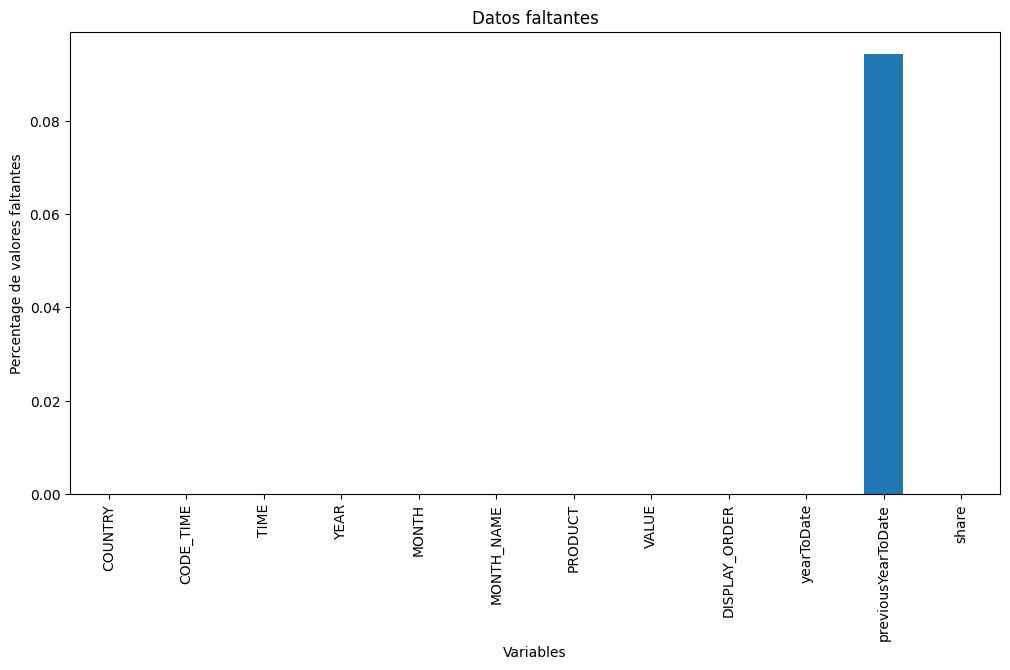

In [11]:
df_clean.isnull().sum()

# Alternativamente podemos usar mean() con isnull() para visualizar el porcentaje de varoleres faltantes en cada variable
df_clean.isnull().mean()

# Podemos tambien graficar el porcentaje de valores faltantes con 
# pandas plot.bar()

df_clean.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage de valores faltantes')
plt.xlabel('Variables')
plt.title('Datos faltantes')

# Filtrar datos a solo Colombia, Estados Unidos y Brazil

In [12]:
# Filtrar solo los países deseados
df_filtered = df_clean[df_clean["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]
df_filtered["COUNTRY"].value_counts()


COUNTRY
United States    4104
Colombia         2548
Brazil           2328
Name: count, dtype: int64

In [13]:
df_filtered.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
940,United States,JAN2010,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15
941,United States,JAN2010,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15
942,United States,JAN2010,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10
943,United States,JAN2010,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16
944,United States,JAN2010,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16


/tmp/ipykernel_17698/1801164000.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")


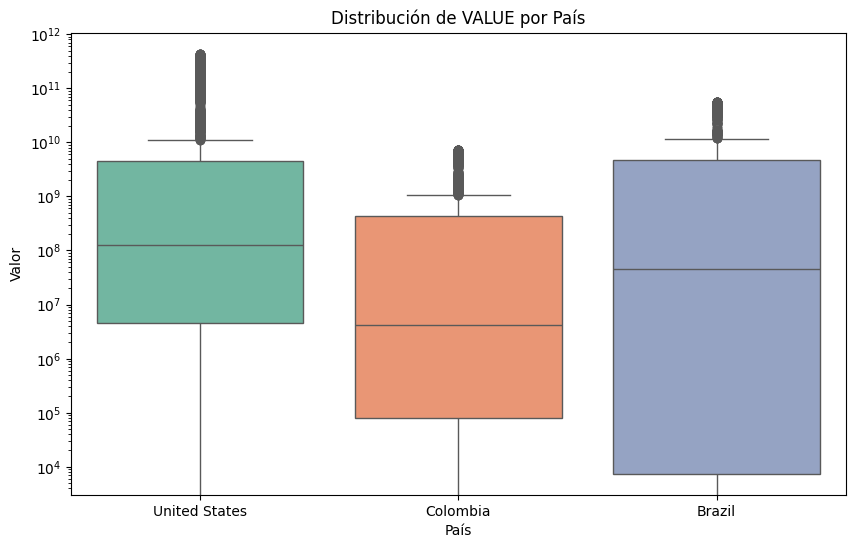

In [14]:
# Filtrar los datos solo para Colombia, Brasil y Estados Unidos
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear un boxplot para visualizar la distribución de VALUE por país
plt.figure(figsize=(10, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")

# Configuración de la gráfica
plt.title("Distribución de VALUE por País")
plt.xlabel("País")
plt.ylabel("Valor")
plt.yscale("log")  # Escala logarítmica si los valores tienen mucha variación
plt.show()

In [15]:
num_unique_products = df["PRODUCT"].nunique()

# Obtener la lista completa de valores únicos
unique_products = df["PRODUCT"].unique()

# Mostrar resultados
print(f"Cantidad de valores únicos en 'PRODUCT': {num_unique_products}")
print("Lista de valores únicos:")
print(unique_products)

Cantidad de valores únicos en 'PRODUCT': 27
Lista de valores únicos:
['Hydro' 'Wind' 'Solar' 'Geothermal' 'Total combustible fuels' 'Coal'
 'Oil' 'Natural gas' 'Combustible renewables' 'Net electricity production'
 'Electricity supplied' 'Used for pumped storage' 'Distribution losses'
 'Final consumption' 'Renewables' 'Non-renewables' 'Others'
 'Other renewables aggregated' 'Low carbon' 'Fossil fuels'
 'Other combustible non-renewables' 'Not specified' 'Total imports'
 'Total exports' 'Electricity trade' 'Nuclear' 'Other renewables']


Grafica de "Value" por país y tipo de generación eléctrica

/tmp/ipykernel_17698/758655413.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


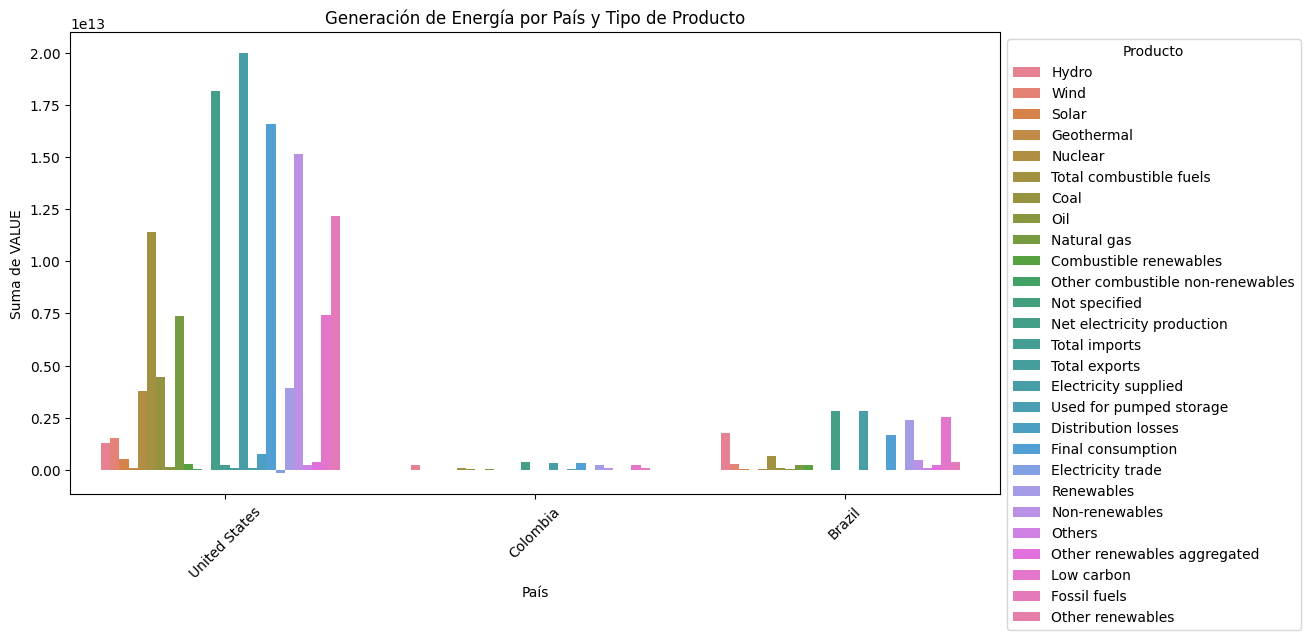

In [16]:
# Filtrar solo los países de interés
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto")
plt.xlabel("País")
plt.ylabel("Suma de VALUE")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

# Transformación Logaritmica para ver mejor los datos

/tmp/ipykernel_17698/3804807995.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


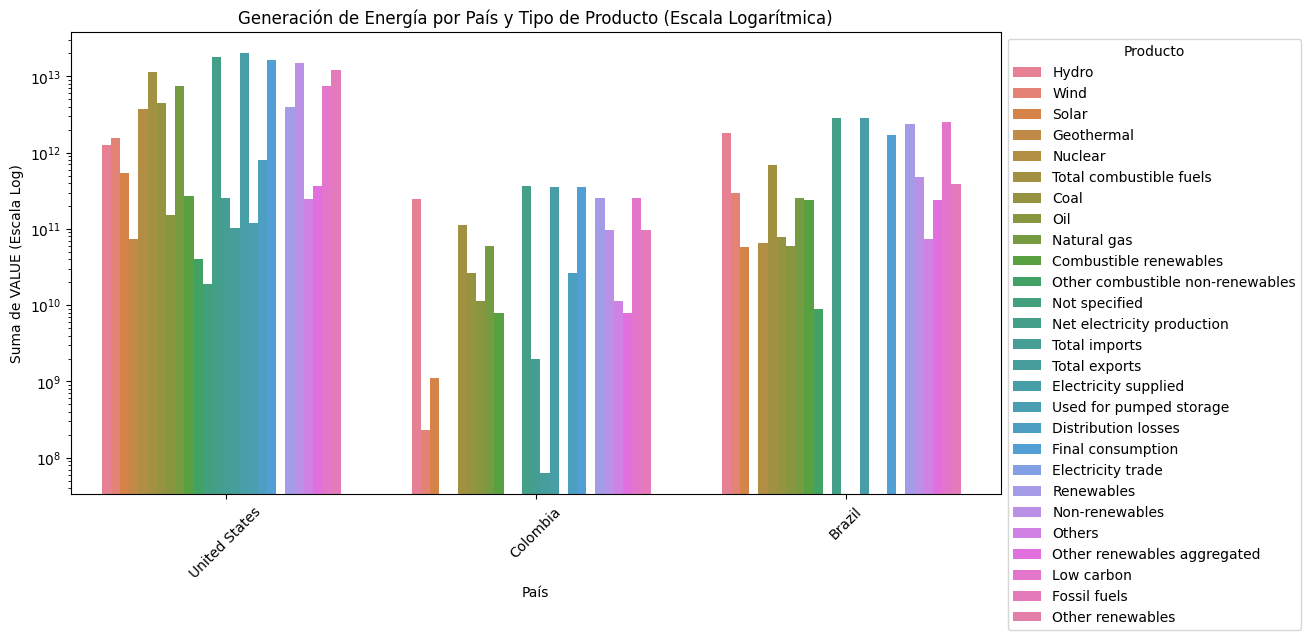

In [17]:
# Crear la gráfica de barras con escala logarítmica
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Aplicar escala logarítmica en el eje Y
plt.yscale("log")

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto (Escala Logarítmica)")
plt.xlabel("País")
plt.ylabel("Suma de VALUE (Escala Log)")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

/tmp/ipykernel_17698/1618507202.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
/tmp/ipykernel_17698/1618507202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])


Correlación con COUNTRY:
COUNTRY_encoded       1.000000
yearToDate            0.195707
VALUE                 0.189524
previousYearToDate    0.152094
share                 0.080199
DISPLAY_ORDER         0.019640
PRODUCT_encoded       0.015683
MONTH                 0.000207
YEAR                 -0.326722
Name: COUNTRY_encoded, dtype: float64

Correlación con PRODUCT:
PRODUCT_encoded       1.000000
share                 0.065421
COUNTRY_encoded       0.015683
YEAR                  0.010839
MONTH                 0.000051
previousYearToDate   -0.088487
yearToDate           -0.099100
VALUE                -0.110250
DISPLAY_ORDER        -0.133396
Name: PRODUCT_encoded, dtype: float64


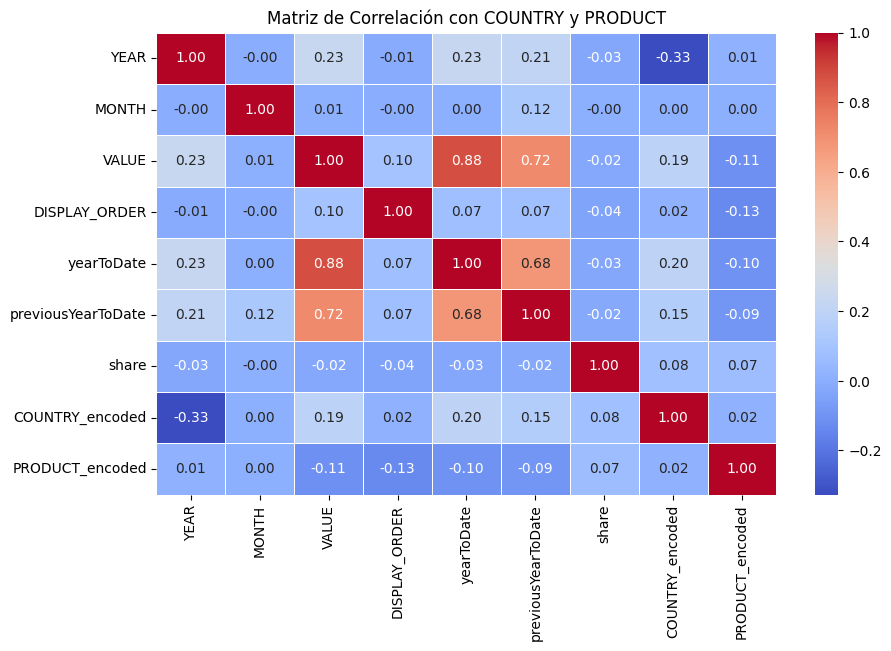

In [29]:
# Codificar las columnas COUNTRY y PRODUCT a valores numéricos
encoder_country = LabelEncoder()
encoder_product = LabelEncoder()

df_filtered["COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
df_filtered["PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr(numeric_only=True)

# Extraer solo la correlación con "COUNTRY_encoded" y "PRODUCT_encoded"
corr_with_country = corr_matrix["COUNTRY_encoded"].sort_values(ascending=False)
corr_with_product = corr_matrix["PRODUCT_encoded"].sort_values(ascending=False)

# Mostrar las correlaciones más altas
print("Correlación con COUNTRY:")
print(corr_with_country)

print("\nCorrelación con PRODUCT:")
print(corr_with_product)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación con COUNTRY y PRODUCT")
plt.show()

plt.show()

Se elimina la columna "code_time", ya que se considera poco relevante

In [23]:
df_filtered.drop(columns=["CODE_TIME"], inplace=True, errors="ignore")


/tmp/ipykernel_17698/52051340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=["CODE_TIME"], inplace=True, errors="ignore")


In [25]:
df_filtered.head()

,COUNTRY,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share,COUNTRY_encoded,PRODUCT_encoded
940,United States,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15,2,8
941,United States,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15,2,26
942,United States,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10,2,21
943,United States,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16,2,7
944,United States,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16,2,14


In [28]:
# Definir función para detectar outliers usando el rango intercuartil (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartil
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

# Detectar outliers en VALUE por país y producto dentro de df_filtered
for pais in df_filtered["COUNTRY"].unique():
    for producto in df_filtered["PRODUCT"].unique():
        df_filtrado = df_filtered[(df_filtered["COUNTRY"] == pais) & (df_filtered["PRODUCT"] == producto)]
        outliers = detectar_outliers(df_filtrado, "VALUE")
        
        if not outliers.empty:
            print(f"Outliers en {pais} - {producto}:")
            print(outliers[["COUNTRY", "PRODUCT", "VALUE"]], "\n")


Outliers en United States - Solar:
              COUNTRY PRODUCT         VALUE
172668  United States   Solar  1.754040e+10
173823  United States   Solar  1.970431e+10
174978  United States   Solar  2.070308e+10
176133  United States   Solar  2.037332e+10
177287  United States   Solar  1.859066e+10
178442  United States   Solar  1.743742e+10 

Outliers en United States - Oil:
              COUNTRY PRODUCT         VALUE
103066  United States     Oil  8.605433e+09
181896  United States     Oil  7.130296e+09 

Outliers en United States - Not specified:
              COUNTRY        PRODUCT         VALUE
162435  United States  Not specified  1.204946e+09 

Outliers en United States - Total exports:
              COUNTRY        PRODUCT         VALUE
119597  United States  Total exports  3.465578e+09
120974  United States  Total exports  3.936460e+09
122351  United States  Total exports  4.830144e+09
123728  United States  Total exports  4.776011e+09
125105  United States  Total exports  4.070

In [37]:
# Ver cuántos valores nulos tiene cada columna
print(df_filtered.isnull().sum())

# Imputar valores numéricos con la mediana
df_filtered.fillna(df_filtered.median(numeric_only=True), inplace=True)

# Imputar valores categóricos con la moda
for col in df_filtered.select_dtypes(include=['object']):
    df_filtered[col].fillna(df_filtered[col].mode()[0], inplace=True)


COUNTRY                 0
TIME                    0
YEAR                    0
MONTH                   0
MONTH_NAME              0
PRODUCT                 0
VALUE                   0
DISPLAY_ORDER           0
yearToDate              0
previousYearToDate    975
share                   0
COUNTRY_encoded         0
PRODUCT_encoded         0
dtype: int64


/tmp/ipykernel_17698/3618973055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.fillna(df_filtered.median(numeric_only=True), inplace=True)
/tmp/ipykernel_17698/3618973055.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col].fillna(df_filtered[col].mode()[0], inplace=True)
/tmp/ipykernel_17698/3618973055.py:9: S

### analisis de la distribución de Value por Pais para saber si hay cesgos

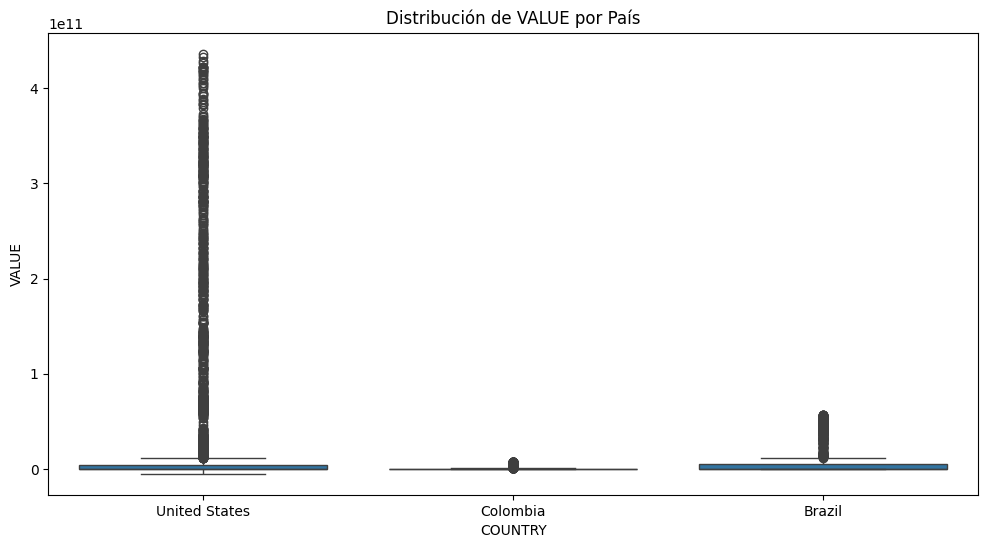

In [38]:


plt.figure(figsize=(12, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered)
plt.title("Distribución de VALUE por País")
plt.show()


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_filtered['VALUE'] = scaler.fit_transform(df_filtered[['VALUE']])


/tmp/ipykernel_17698/243625984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['VALUE'] = scaler.fit_transform(df_filtered[['VALUE']])
